# Archivos base

In [ ]:
#  para que funcione unfolding y precompile quantum: Pkg.add("LsqFit")
push!(LOAD_PATH, ".");
using quantum
using PyPlot

In [ ]:
@which base_state

In [ ]:
@which base_state(1,3)

In [ ]:
@edit base_state(1,3)

# Los ensambles a estudiar y la distribución de primeros vecinos

## El PUE o ensamble poissoniano

Estudiaremos primero una secuencia de números aleatoria y veremos una de sus propiedades mas simples.

In [175]:
n=100;
random_spectrum=sort(2*pi*rand(n));

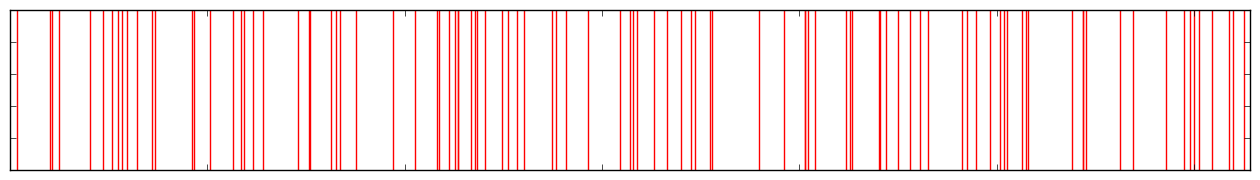

In [224]:
fig = figure()
w, h = plt[:figaspect](0.1)
figure(figsize=(w,h))
PyPlot.xlim(0,2*pi);
#figure(axis="on"")
for energy in random_spectrum
    plot([energy, energy], [0, 1], color="red");
end
#axis("off")
tick_params(labelbottom="off",labelleft="off")

## La distribución de primeros vecinos para el PUE

Ahora consideraremos la distribución de espaciamientos a primeros vecinos, normalizada a un promedio de 1.

`sort` sirve para ordenar  
`circshift` hace un shift circular al arreglo  
`mean` sirve para sacar promedios

In [ ]:
function get_nearest_neighbour(spectrum)
    a=sort(spectrum)
    a=a-circshift(a,1)
    a[1]=a[1]+2*pi
    a/mean(a)
end

In [ ]:
function P_Poisson(x)
    return exp(-x)
end

In [ ]:
x=linspace(0,6,700);
y=P_Poisson(x);
PyPlot.xlim(0,6)
PyPlot.plot(x,y);
n=4000;
plt[:hist](get_nearest_neighbour(2*pi*rand(n)),50,normed="True");
plt[:show](figure)

## El ensamble CUE

Consideremos una matriz $H$ hermítica con entradas distribuidas de manera gaussiana (sobre la diagonal el ancho es un factor $\sqrt{2}$ mayor). Por los mismo argumentos que expusimos para estados aleatorios, esta matriz no tiene una dirección preferencial, ya que al hacerle una transformación unitaria, $U H U^\dagger$, los elementos tienen la misma distrubución anterior. 

La forma de construir dicha matriz es tomando una matriz con entradas complejas gaussianas identicamente distribuidas, y sumándole su transpuesta conjugada:
\begin{equation}
H = A+A^\dagger.
\end{equation}
Vamos a decir, sin mayor explicación, que las matrices así generadas pertecen al GUE o _Gaussian Unitary Ensemble_. Vamos a programarlas usando funciones anónimas.

In [ ]:
function gaussian_unitary_ensemble(dim)
    (x -> x+x')(randn(dim,dim)+im*randn(dim,dim))
end

Dado que no tienen una dirección preferencial, sus eigenvectores forman una base ortonormal aleatoria, con respecto a la medida de Haar. Bastaría hacer una diagonalización para tener una base totalmente aleatoria. Sin embargo, dada la arbitrariedad en la fase, Julia hace que el último elemento del vector sea real. Esto hay que solucionarlo artificialmente, multiplicando cada vector por una fase aleatoria entre $0$ y $2\pi$. 

In [ ]:
dim=3;
a=eigvecs(gaussian_unitary_ensemble(dim))

Esto hay que solucionarlo artificialmente, multiplicando cada vector por una fase aleatoria entre $0$ y $2\pi$. Esto lo vamos a hacer multiplicando no vectorialmente, sino elemento a elemento usando 
```
.*
```

In [ ]:
a.*exp(2*pi*im*rand(dim))'

Así, formamos finalmente la función `circular_unitary_ensemble`

In [ ]:
function circular_unitary_ensemble(dim::Int)
    eigvecs(gaussian_unitary_ensemble(dim)).*exp(2*pi*im*rand(dim))'
end

Revisemos que la norma de las eigenfases es 1. La función `norm` no es vectorizable en forma trivial, por lo que nos toca usar la función 
```
map
```
que es extremadamente conveniente para escribir cosas en forma compacta y sin usar loops.

In [ ]:
dim=6;
norm(eigvals(circular_unitary_ensemble(dim)))

In [168]:
map(x->norm(x),eigvals(circular_unitary_ensemble(dim)))

3-element Array{Float64,1}:
 1.0
 1.0
 1.0

La distribución de primeros vecinos, no coincide con un espectro aleatorio!

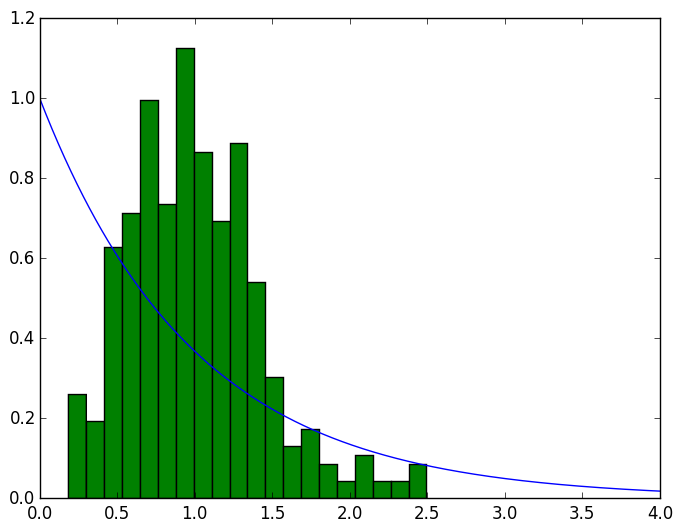

In [190]:
dim=400;
max_x=4;
s=get_nearest_neighbour(angle(eigvals(circular_unitary_ensemble(dim))))


x=linspace(0,max_x,700);
y=P_Poisson(x);
PyPlot.xlim(0,max_x)
PyPlot.plot(x,y);
plt[:hist](s,20,normed="True");
plt[:show](figure)


Dado que diagonalizar matrices es relativamente dificil conforme crece la dimensión del sistema, vamos a usar ensambles, considerando no un ensemble de espectros, sino un ensemble de distribuciones de primeros vecinos. Entonces, usamos el _Wigner surmize_ del GUE. 

In [219]:
dim=100;
EnsembleSize=1000;
data=zeros(EnsembleSize*dim)
for i=1:EnsembleSize
    data[((i-1)*dim+1):i*dim]=get_nearest_neighbour(angle(eigvals(circular_unitary_ensemble(dim))))
end

In [222]:
function Wigner_surmise_GUE(x)
    return (x.^2*32/pi^2).*exp(-x.^2*4/pi)
end

Wigner_surmise_GUE (generic function with 1 method)

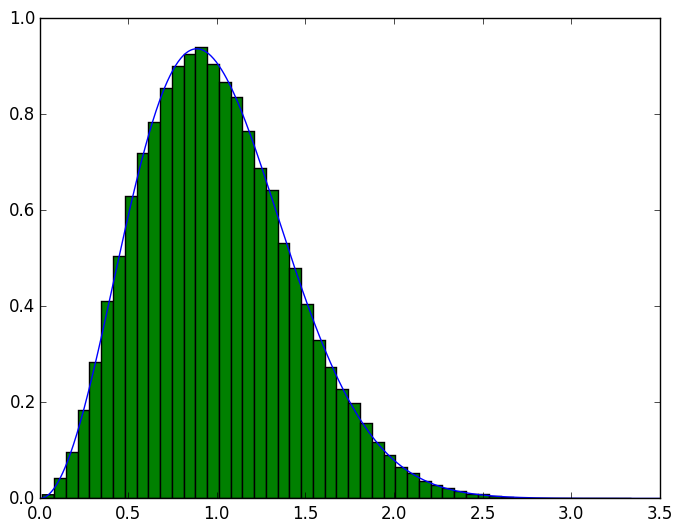

In [225]:
max_x=3.5
x=linspace(0,max_x,700);
y=Wigner_surmise_GUE(x);
PyPlot.xlim(0,max_x)
PyPlot.plot(x,y);
plt[:hist](data,50,normed="True");
plt[:show](figure)


# Caos Cuántico y Teoria de Matrices Aleatorias

La _teoría de matrices aleatorias_ (random matrix theory, o RMT) fue usada en física por primera vez para tratar de caracterizar el espectros de resonancias de los núcleos atómicos pesados por Wigner. El postuló que las propiedades estadísticas de las fluctuaciones de las líneas espectrales siguen el comportamiento de los eigenvalores de un ensamble de matrices aleatorias,  y que este ensamble depende sólo de la clase de simetría de la dinámica subyacente. Más adelante, en el año 1984, Bohigas, Giannoni, y Schmit acuñaron una __conjetura que establece que sistemas clásicos caóticos, al ser cuantizados, muestran una estadística espectral tipo RMT__. RMT comenzó a formar un pilar y una herramienta para el estudio del caos cuántico, a tal grado que hoy en día algunos la usan para _definir_ caos cuántico.

_Lo anterior dicho constituye un resultado sorprendente dado que define clases de universalidad que dependen solo del grupo de transformaciones canónicas ante las cuales el sistema es invariante._

Tres ensambles son típicamente considerados para matrices hermitianas:

* _Gaussian Unitary Ensemble_ __(GUE)__ :Ensamble de matrices invariantes ante transformaciones unitarias. Este puede ser considerado como un ensamble de Hamiltonianos no simétricos bajo inversión temporal.  

* _Gaussian Orthogonal Ensemble_ __(GOE)__: Modela Hamiltonianos invariantes ante transformaciones ortogonales y describe sistemas que son ya sea (i) simétricos ante inversión temporal y de espín total semientero, o (ii) sistemas de espín entero que pudieran tener o no simetría ante rotaciones. 

* _Gaussian Symplectic Ensemble_ __(GSE)__: Ensamble de matrices hermitianas invariante ante transformaciones simplécticas. Este tipo de matrices gobiernan la dinámica de sistemas de espín semientero simétricos bajo inversión temporal y carentes simetría bajo rotaciones.

Existen también ensambles equivalentes de matrices unitarias (que pueden representar matrices de dispersión y operadores de Floquet). Estos son llamados ensambles "circulares" _Circular Gaussian Ensembles_ que, bajo  consideraciones similares de los ensambles anteriores, se denotan como CUE, COE y CSE. Análogamente para estos últimos ensambles se estudia, por ejemplo, el espaciamiento de las comúnmente llamadas cuasi-energías.  Concretamente, un sistema cuántico caótico con una de las tres simetrias internas antes mencionadas, su distribución de las diferencias en las energias (ó cuasienergias) están bien aproximadas por las siguientes distribuciones:
\begin{equation}
P(s)=\begin{cases} 
      \hfill (s \pi /2)\exp (-s^2\pi/4)    \hfill & \text{ortogonal} \\
      \hfill (s^2 32/\pi^2) \exp (-s^2 4/\pi)    \hfill & \text{unitario} \\
      \hfill (s^4 2^{18}/3^6 \pi^3)\exp (-s^2 64/9 \pi)    \hfill & \text{simpléctico.}
  \end{cases}
\end{equation}
Cabe decir que para $s$ pequeña uno puede notar el exponente de
_repulsión_ entre los eigenvalores en los distintos ensambles, $P(s)
\sim s^\beta$, $\beta=1,2,4$ para el ensamble ortogonal, unitario y simpléctico
respectivamente. La repulsion de los niveles cuando el parámetro del sistema que lo lleva desde el régimen integral hasta el caótico, se ve en acción como sigue:

![title](Statisticsmath2.png "Title")

Para sistemas integrables, típicamente la $P(s)$ imita el comportamiento del _Poissonian unitary (orthogonal, symplectic) ensemble_, es decir, matrices que pueden ser escritas como $H=UDU^\dagger$, donde D es una matriz diagonal con entradas aleatorias bajo la misma distribución y sin correlación alguna. 

# Cadena de espines pateada

## Descripción

* Estudiaremos una cadena de Ising abierta pateada por pulsos de campo magnético. El Hamiltoniano del sistema es el siguiente:
$$
H_{\text{env}}=\sum_{i=0}^{N-2} J_i\sigma^z_i \sigma_{i+1}^z 
  +\hat  \delta_{\tau}(t) \sum_{i=0}^{N-1} b^{ \perp }\sigma_i^x +b^{\parallel} \sigma_i^z, 
 \hspace{8 pt} 
\hat \delta_{\tau}(t)=\sum_{n=-\infty}^{\infty} \delta(t-\tau n),
$$

__Simetrías:__
    
La cadena homogénea $J_i = J$ tiene simetría bajo reflexión, es decir, si cambiamos el qubit $i \to N-1-i$, el Hamiltoniano queda invariante. El operador de simetría asociado $R$, opera en la base computacional como sigue:
$$R\vert\alpha_0,\alpha_1,\dots,\alpha_{N-2},\alpha_{N-1}\rangle=\vert\alpha_{N-1},\alpha_{N-2},\dots,\alpha_{1},\alpha_0\rangle.$$
donde $\alpha_j\in\lbrace 0,1 \rbrace$, los eigenvalores asociados a este operador son $\pm 1$. 

Cabe notar que las simetrías están asociadas a cantidades conservadas y viceversa, en este caso es la paridad y el espacio de Hilbert esta estructurado como sigue:
$$\mathcal{H}=\mathcal{H}_1\oplus \mathcal{H}_{-1}.$$
donde $\mathcal{H}_{\pm 1}$ son subespacios invariantes asociados a cada valor de la paridad, es decir, si un estado vive inicialmente en $\mathcal{H}_1$ y se propaga de acuerdo al Hamiltoniano de arriba, el estado del sistema se quedara en ese espacio.

__Operador de evolución__ 

Cuando se tiene un Hamiltoniano con dependencia explícita en el tiempo, el operador de evolución se construye como sigue:

\begin{equation}
U(t_2,t_1)=\mathcal{T} \exp{\left(-i\int_{t_1}^{t_2} H(t) dt\right)},
\end{equation}

donde $\mathcal{T}$ es el operador de ordenamiento temporal. Sin embargo, dado
que el Hamiltoniano es periódico en el tiempo [$H(t+\tau)=H(t)$] y la
dependencia temporal viene en términos de deltas de Dirac, uno puede
simplificar bastante la expresión anterior y lidiar con un mapeo estroboscópico
cuántico que se calcula de la siguiente manera. Entre cada patada, el sistema
se comporta como uno autónomo y el operador de evolución viene dado solo por la
parte de Ising. Justo después de una patada y durante un tiempo menor al
periodo del sistema, el operador de evolución viene dado por (digamos justo
después de la
patada $n$):
$$U_I(t)=\exp \left( -i t H_I \right), \hspace{8 pt} n \tau<t<(n+1)\tau$$
donde $H_I$ denota solo la parte de Ising del Hamiltoniano total de la cadena.
Ahora, en un intervalo de tiempo pequeño alrededor de cuando la patada $m=n+1$
ocurre, la parte del campo magnético del Hamiltoniano es mucho más fuerte que
la parte de Ising y el operador de evolución en la vecindad de la patada esta
dado por:
\begin{align*}
U_K = \lim_{\epsilon \to 0^+} U(m \tau-\epsilon, m \tau + \epsilon) 
       &= \lim_{\epsilon \to 0^+} \mathcal{T}
           \exp \left( -i H_K\int_{m \tau -\epsilon}^{m \tau +\epsilon} 
	              \delta_\tau(t) dt \right)\\
       &= \exp \left( -i H_K \right),
\end{align*}
donde $H_K=\sum_{i=0}^{N-1} b^{ \perp }\sigma_i^x +b^{\parallel} \sigma_i^z$.
Por lo tanto el operador de evolución que mapea estados a justo después de la
patada $n$ está dado por:
\begin{equation}
U_{KI}(n \tau) = \left[U_K U_I(\tau)\right]^n,
\end{equation}
donde $U_{I}=\exp\left( -i \sum_{i=0}^{N-1} J_i \sigma^z_i \sigma_{i+1}^z\right)$ y $U_\text{K}=\exp \left(-i \sum_{i=0}^{N-1} b^{ \perp }\sigma_i^x +b^{\parallel} \sigma_i^z \right)$. Entonces:
$$\vert \psi(\tau (n+1))\rangle=U_{\text{KI}}(\tau)\vert \psi(\tau n)\rangle.$$

Por último la cadena es simétrica bajo inversión temporal. En la base computacional, el operador de inversión temporal, $K'$ es simplemente conjugación compleja, tenemos entonces, $K'\sigma_{x,z} K'^{-1}=\sigma_{x,y}$ y
$K' \sigma_y K'^{-1}=-\sigma_y$. Usando la versión simetrizada del operador de Floquet, $U'_{KI}=\exp(-iH_I/2)U_{KI}\exp(iH_I/2)$, es fácil comprobar que
\begin{equation}
K'U'_{KI}K'^{-1}=U'^{\dagger}_{KI},.
\end{equation}
es decir, el operador de evolución se comporta "bien" bajo inversion temporal, puesto que el complejo transpuesto de $U'$ es el que propaga estados en reversa. Se dice que $U'$ es covariante bajo la operación de inversión temporal.
Por lo tanto para el régimen caótico en la cadena tenemos una
correspondencia de la $P(s)$ con el resultado del ensamble COE.

__Regimenes__

* Integrable: $b^{\parallel} = 0$ o $b^{\perp} = 0$ 

* Caótica: $b^{\parallel} \approx b^{\perp}$ y no demasiado pequeñas

Para estudiar el espectro de la cadena uno lo tiene que hacer en cada sector de simetría, sin embargo, en lo que sigue estudiaremos la cadena homogénea con un defecto, éste remueve explícitamente la simetría de reflexión, quedando solo la simetría antiunitaria. De hecho la simetría antiunitaria la vamos a remover añadiendo una patada en otra dirección. 

__Cadena con un defecto__

Para esto fijaremos $J_i=J_{\text{hom}}$ para $i=0, \dots, j-1,j+1, \dots N-2$ y el defecto será modelado con un acoplamiento de Ising diferente $J_j=J_{\text{inhom}}$.

## Propagador de la cadena

In [264]:
"""
Se construye la parte de Ising de una cadena abierta homogenea
"""
function apply_open_chain!(psi,J)
    qubits=trailing_zeros(length(psi))
    for i in 0:(qubits-2) 
        apply_ising!(psi,J,i,i+1)
    end
end
"""
Se construye la parte de Ising inhomogenea
"""
function apply_open_inhomogeneous_chain!(psi,J_hom,J_inhom)
    qubits=trailing_zeros(length(psi))
    apply_open_chain!(psi,J_hom)
    apply_ising!(psi,J_inhom-J_hom,Int(round(qubits/2)-1),Int(round(qubits/2)))
end
"""
Se construye la parte del campo de una cadena de espines
"""
function apply_magnetic_kick!(psi,b)
    qubits=trailing_zeros(length(psi))
    for i in 0:(qubits-1) 
        apply_kick!(psi,b,i)
    end
end;

## Operador de Floquet

In [274]:
"""
floquet_open_chain(J,bx,bz,qubits::Int) Operador de Floquet de una cadena abierta y homogenea
"""
function floquet_open_chain(J,b,qubits::Int)
    dim=Int(2^qubits)
    u=zeros(Complex{Float64},dim,dim)
    for i in range(0,dim)
        psi=copy(base_state(i,dim))
        apply_open_chain!(psi,J)
        apply_magnetic_kick!(psi,b)
        u[:,i+1]=psi
    end
    return u
end

"""
floquet_open_inhomogeneous_chain(J_hom,J_inhom,bx,bz,qubits::Int) Operador de Floquet de una cadena abierta 
e inhomogenea
"""
function floquet_open_inhomogeneous_chain(J_hom,J_inhom,b,qubits::Int)
    dim=Int(2^qubits)
    u=zeros(Complex{Float64},dim,dim)
    for i=0:(dim-1)
        #@show i
        psi=copy(base_state(i,dim))
        #@show "hola 1", i
        apply_open_inhomogeneous_chain!(psi,J_hom,J_inhom)
        #@show "hola 2", i

        apply_magnetic_kick!(psi,b)
        u[:,i+1]=psi
    end
    return u 
end

function floquet_chain(J_hom,J_inhom,J_hom_2,J_inhom_2,b,b2,qubits::Int)
    dim=Int(2^qubits)
    u=zeros(Complex{Float64},dim,dim)
    for i in range(0,dim)
        psi=copy(base_state(i,dim))
        apply_magnetic_kick!(psi,b)
        apply_open_inhomogeneous_chain!(psi,J_hom,J_inhom)
        apply_magnetic_kick!(psi,b2)
        apply_open_inhomogeneous_chain!(psi,J_hom_2,J_inhom_2)
        u[:,i+1]=psi
    end
    return u 
end;


## Distribución de las cuasienergias para el régimen caótico de la cadena

In [267]:
U_KI=floquet_open_inhomogeneous_chain(1.0,4.0,[1.4,0.0,1.4],11);

In [268]:
list=angle(eigvals(U_KI));

In [270]:
list2=sort(list,rev=true); # Aqui se ordenan las cuasienergias
listdiff=zeros(length(list)-1); # Calculo de las diferencias
list2=unfolding(list2);
for i in range(1,length(list)-1)
    listdiff[i]=list2[i]-list2[i+1];
end;
# Aqui hacemos el promedio de las diferencias igual a 1.
listdiff=listdiff/mean(listdiff); 

In [275]:
function P_Orthogonal(x)
    return x.*exp(-x.^2*pi/4)*pi/2
end

LoadError: LoadError: error in method definition: function quantum.P_Orthogonal must be explicitly imported to be extended
while loading In[275], in expression starting on line 1

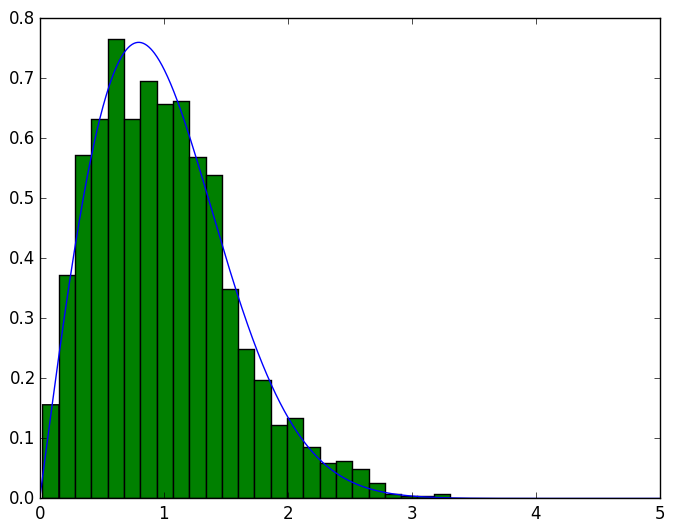

In [272]:
x=linspace(0,5,1000);
y=P_Orthogonal(x);
PyPlot.plot(x,y);
plt[:hist](listdiff,25,normed="True");
plt[:show](figure)

## Distribución de las cuasienergias para el régimen integrable de la cadena

In [276]:
U_KI=floquet_open_inhomogeneous_chain(1.0,4.0,[0.15,0.0,1.4],11);

In [279]:
spectrum=angle(eigvals(U_KI));

In [285]:
listdiff=get_nearest_neighbour(spectrum);

In [286]:
function P_Poisson(x)
    return exp(-x)
end;

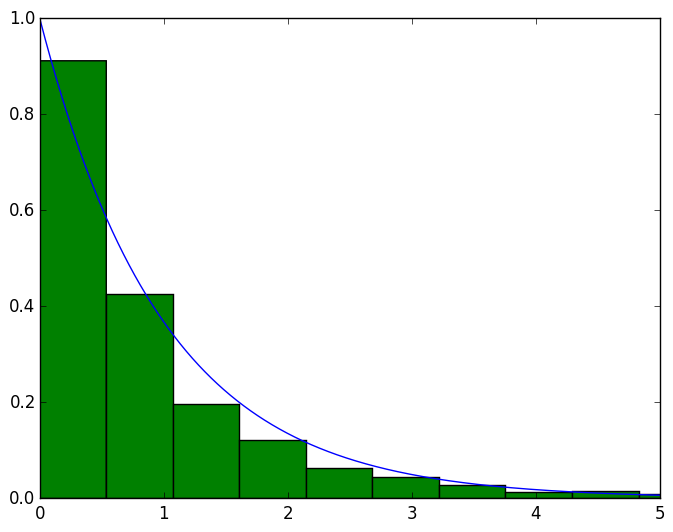

In [284]:
x=linspace(0,5,1000);
y=P_Poisson(x);
PyPlot.plot(x,y);
plt[:hist](listdiff,40,normed="True");
plt[:xlim](0,5);
plt[:show]()

## Cadena sin simetria antiunitaria: Régimen caótico

In [287]:
U_KI=floquet_chain(1.0,1.1,1.0,1.1,[1.4,0.0,1.4],[1.0,1.0,0.0],11);

In [292]:
listdiff=get_nearest_neighbour(angle(eigvals(U_KI)));

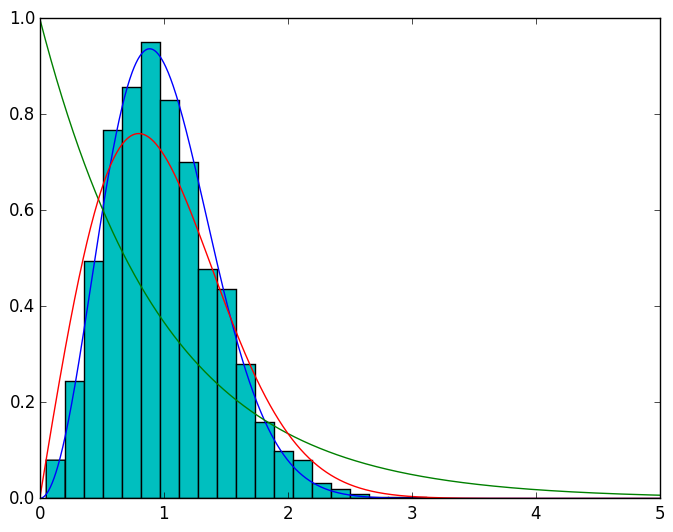

In [293]:
x=linspace(0,5,1000);
y=P_Orthogonal(x);
y2=P_Unitary(x);
y3=exp(-x);
plot(x,y2);
plot(x,y3);
plot(x,y);
plt[:hist](listdiff,20,normed="True");

# Propagador construido explicitamente y test

## terminos ising y de campo

In [ ]:
"""
ising_term(qubits::Int,target_1::Int=1,target_2::Int=target_1+1) Construye la compuerta ``\LaTeX A \times B``
"""
function ising_term(qubits::Int,target_1::Int=1,target_2::Int=target_1+1)
    
    array=Array{Float64,2}[]
    
    for i in range(1,qubits)
        
        if i==target_1
            push!(array,sigma_z)
            elseif i==target_2
            push!(array,sigma_z)
        else
            push!(array,eye(2)) 
        end
        
    end
    
    return kron(array...)
    
end

function sigma_term(qubits::Int,target::Int,j::Int)
    array=Array{Complex{Float64},2}[]
    
    for i in range(1,qubits)
        if i==target
            push!(array,sigmas[j])
        else
            push!(array,eye(2))
        end
    end
    return kron(array...)
end

In [ ]:
@less kronsigma_term

In [ ]:
code_typed(sigma_term,(Int,Int,Int))

In [ ]:
less(kron)

## Hamiltonianos

In [ ]:
function ham_ising_open_hom(qubits::Int,J)
    
    h=zeros(Int(2^qubits),Int(2^qubits))
    
    for i in range(1,qubits-1)
        h=ising_term(qubits,i)+h
    end
    
    return J*h
    
end

function ham_ising_open_inhom(qubits::Int,J_hom,J_inhom)
    
    h=zeros(Int(2^qubits),Int(2^qubits))
    for i in range(1,qubits-1)
        h=ising_term(qubits,i)+h
    end
    h=J_hom*h+ising_term(qubits,Int(round(qubits/2)-1))*(J_inhom-J_hom)
    
    return h
    
end

In [ ]:
function ham_field_hom(qubits::Int,b_x,b_z)
    
    h=zeros(Int(2^qubits),Int(2^qubits))
    
    for i in range(1,qubits)
        h=b_x*sigma_term(qubits,i,1)+b_z*sigma_term(qubits,i,3)+h
    end
    
    return h
    
end

## test

In [ ]:
# Se comparan los operadores de floquet de la cadena inhomogenea con acoplamientos Ising aleatorios
J_hom=rand(1)[]
J_inhom=rand(1)[]
H_I=ham_ising_open_inhom(7,J_hom,J_inhom);
H_K=ham_field_hom(7,2.0,1.0);

In [ ]:
U_I=expm(-1.0im*H_I);

In [ ]:
U_K=expm(-1.0im*H_K);

In [ ]:
U_KI=U_K*U_I;

In [ ]:
norm(U_KI-floquet_open_inhomogeneous_chain(J_hom,J_inhom,[2.0,0.0,1.0],7))

# Para la siguiente iteracion

* Poner la prueba del _Wigner surmise_ para dos niveles.
* Incluir explicitamente la prueba de que $H$, si tiene elementos gaussianos, con ancho en la diagonal un poco mas grande, es invariante bajo transformaciones unitarias.
* Construir una función anónima que me calcule las eigenenergías de cada 